In [1]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageOps
from torchvision import models
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
import pandas as pd
import os 
import time
import cv2
import torchvision
import math

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Introduction

I have long been interested in Visual Transformers and Attention. Since there is no way to learn by doing this is me implementing the core concepts from scratch using Pytorch.

The core concept of a Visual Transformer is that it will first cut up the images into seperate patches that will then be fed into linear embeddings. These embeddings will have attention applied to them. Using this attention we will the pass the original image data with the attention into a Multi Layer Perceptron and see what kind of classification accuracy we can achieve.

I am mainly trying to hash out the concept of visual transformers in my head and hopefully I can help you learn along with me.

# Load Data and Reshape Into Images

Here I will load the data from the csv files and load them into square shaped images. I do that here rather than training to speed things up a little at training time where otherwise this reshaping would need to occur every training epoch.

In [2]:
df = pd.read_csv('../input/digit-recognizer/train.csv', delimiter=',').to_numpy()
test_df = pd.read_csv("../input/digit-recognizer/test.csv", delimiter=',').to_numpy()
df = df[1:]
y = df[:,0]
X = df[:,1:]
X = X / 255

test_X = test_df[1:] / 255
_, *test_y = range(len(test_X)) 

new_X = []
for i in range(len(X)):
    new_X.append(X[i].reshape(28,28))
X = new_X
new_test_X = []
for i in range(len(test_X)):
    new_test_X.append(test_X[i].reshape(28,28))
test_X = new_test_X

## Investigating the dataset

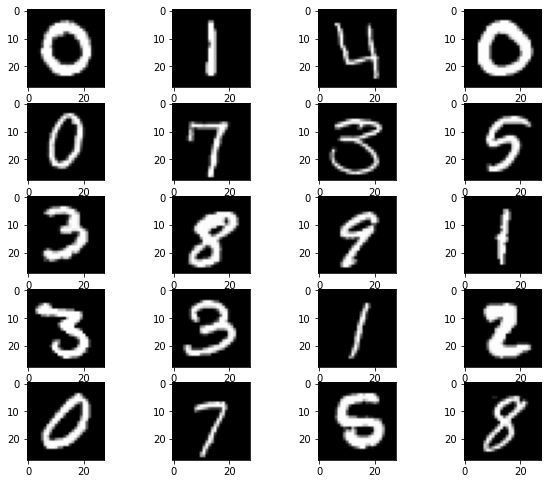

In [3]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10,10)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        image = Image.fromarray(img * 255)
        plt.subplot(int(num_samples/cols + 1), cols, i + 1)
        plt.imshow(image)

show_images(X)

# Create Dataset and Dataloader

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, X, y, BatchSize, Transforms):
    super().__init__()
    self.BatchSize = BatchSize
    self.y = y
    self.X = X
    self.transform = Transforms
    
  def num_of_batches(self):
    """
    Detect the total number of batches
    """
    return math.floor(len(self.list_IDs) / self.BatchSize)

  def __getitem__(self,idx):
    class_id = self.y[idx]
    img = self.X[idx]
    return self.transform(img).squeeze(), torch.tensor(int(class_id))

  def __len__(self):
    return len(self.X)
    
# Define Transforms
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])

train_ratio = 0.90

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1 - train_ratio, stratify = y, random_state = 0)

dataset_stages = ['train', 'val', 'test']

batch_size = 32
image_datasets = {'train' : CustomDataset(X_train, y_train, batch_size, transform), 'val' : CustomDataset(X_val, y_val, batch_size, transform), 'test' : CustomDataset(test_X, test_y, batch_size, transform)}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=image_datasets[x].BatchSize, shuffle=False, num_workers=0) 
               for x in dataset_stages}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Define Positional Encoding

This will be a series of static values that will be fed into the network so that it can determine the location of each patch of the image it is being fed. Without this information the transformer's task would be unneccesarily difficult, like being given a bunch of jigsaw pieces and having to fit them together each time. 

In [5]:
def getPositionEncoding(sequence_len, output_dim, n=10000):
    P = torch.zeros((sequence_len, output_dim))
    for k in range(sequence_len):
        for i in torch.arange(int(output_dim/2)):
            denominator = torch.pow(torch.Tensor([n]), torch.Tensor([2*i/output_dim]))
            P[k, 2*i] = torch.sin(k/denominator)
            P[k, 2*i+1] = torch.cos(k/denominator)
    return P

P = getPositionEncoding(sequence_len=4, output_dim=4, n=100)
print(P.shape)

torch.Size([4, 4])


### Visualise the positional embedding output

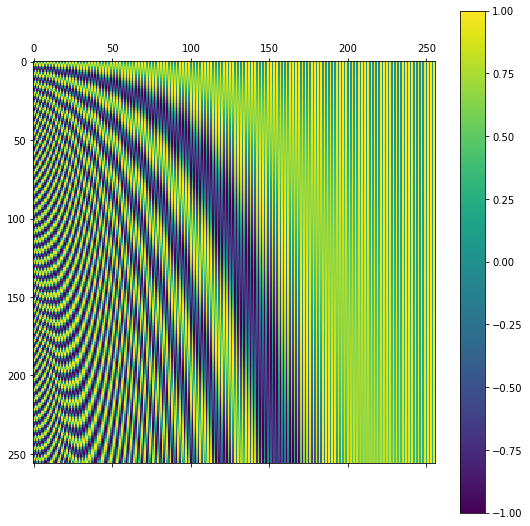

In [6]:
pos_enc = getPositionEncoding(sequence_len=256, output_dim=256, n=1000)
plt.rcParams["figure.figsize"] = (9,9)
pos_enc_graph = plt.matshow(pos_enc)
plt.gcf().colorbar(pos_enc_graph)
print()

### Let's Create a Positional Embedding Network

In [7]:
class PositionalEmbedder(nn.Module):
    def __init__(self, sequence_len = 8, output_dim = 8):
        super().__init__()
        self.linear1 = torch.nn.Linear(sequence_len, output_dim)
        self.linear1.requires_grad = False
        embeddings = getPositionEncoding(sequence_len=sequence_len, output_dim=output_dim, n=10000)
        self.positional_embeddings = torch.nn.Parameter(embeddings)
        self.positional_embeddings.requires_grad = False
        
    def forward(self, x):
        assert len(x.shape) == 3, "dimensions do not equal 3"
        x = self.linear1(x)
        pos_embed = self.positional_embeddings[:x.size()[1],:].expand((x.size()[0], -1, -1))
        x = x + pos_embed
        return x

# Define Transformer

Here I define the transformer and the forward process is probably the most useful part to look at. I have tried to comment the major steps. First I use Pytorch unfold to cut the image into many patches. 

Then I go through and multi headed attention to the patches. 

I finish by using the results of this process to pass through a multilayer perceptron and classify them. 

There is a fair bit going on in the network and I have created some diagrams below to roughly describe the process. I am new to making diagrams so hopefully these prove helpful to you. 

### The Initial Part of the Network

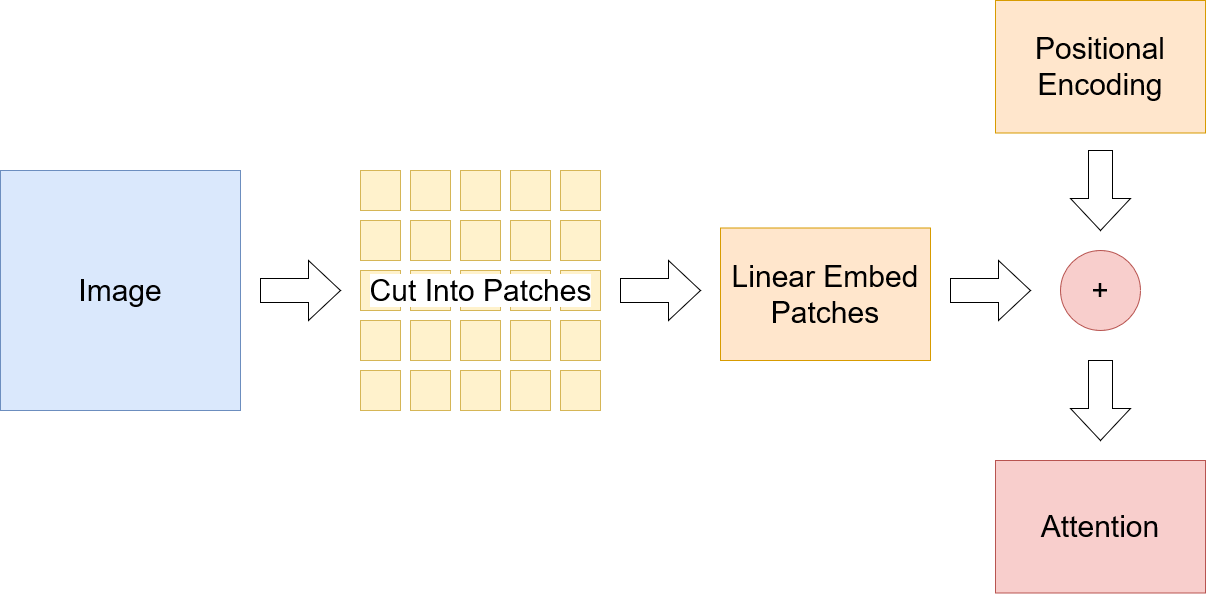

### From the Attention Part:

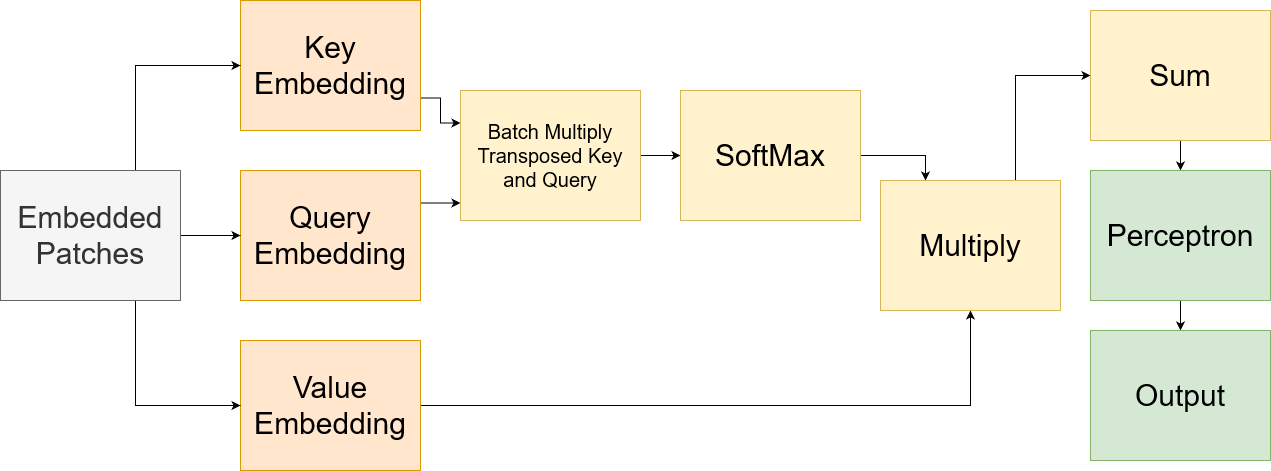

In [8]:
from torch import embedding

class ViTransformer(nn.Module):
    def __init__(self, batch_size = 32, patch_size = 4, attention_heads = 2):
        super().__init__()
        self.patch_size = patch_size
        self.linear_embedding_size = 8
        self.linear1 = torch.nn.Linear(self.patch_size ** 2, self.linear_embedding_size)
        self.linear_attention_patchwise1 = torch.nn.Linear(self.patch_size ** 2, int(self.linear_embedding_size * 2))
        self.linear_attention_patchwise2 = torch.nn.Linear(int(self.linear_embedding_size * 2), int(self.linear_embedding_size * 2))
        self.linear2 = torch.nn.Linear(int(self.linear_embedding_size * 2 * attention_heads), int(self.linear_embedding_size * 2))
        embeddings = getPositionEncoding(sequence_len=98, output_dim=8, n=10000)
        self.positional_embeddings = torch.nn.Parameter(embeddings)
        self.positional_embeddings.requires_grad = False
        self.layer_norm1 = torch.nn.LayerNorm(self.linear_embedding_size * 2)
        self.layer_norm2 = torch.nn.LayerNorm(self.linear_embedding_size * 2)
        self.attention_heads = attention_heads
        self.query_linears = nn.ModuleList([nn.Linear(int(self.linear_embedding_size * 2), int(self.linear_embedding_size * 2)) for i in range(attention_heads)])
        self.key_linears = nn.ModuleList([nn.Linear(int(self.linear_embedding_size * 2), int(self.linear_embedding_size * 2)) for i in range(attention_heads)])
        self.value_linears = nn.ModuleList([nn.Linear(int(self.linear_embedding_size * 2), int(self.linear_embedding_size * 2)) for i in range(attention_heads)])
        self.gammas = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor([1])) for i in range(attention_heads)])
        self.softmax1 = nn.Softmax(2)
        # MLP
        self.linear3 = torch.nn.Linear(1568, 100)
        self.gelu1 = torch.nn.GELU()
        self.linear4 = torch.nn.Linear(100,100)
        self.gelu2 = torch.nn.GELU()
        self.linear5 = torch.nn.Linear(100,10)
        self.softmax2 = nn.Softmax(1)
        self.bn1 = torch.nn.BatchNorm1d(100)
        self.bn2 = torch.nn.BatchNorm1d(100)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)

    def forward(self, x):
        assert len(x.shape) == 4, "dimensions do not equal 4"
        b, c, w, h = x.size()
        # Roll image
        x_clone = x.clone()
        x_clone = torch.roll(x_clone, int(self.patch_size / 2), 2)
        x_clone = torch.roll(x_clone, int(self.patch_size / 2), 3)
        # Cut Images into patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).reshape((b, int((w / self.patch_size) * (h / self.patch_size)), self.patch_size ** 2))
        patches_rolled = x_clone.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).reshape((b, int((w / self.patch_size) * (h / self.patch_size)), self.patch_size ** 2))
        x = torch.cat((patches, patches_rolled), 1)
        x = torch.relu(self.linear1(x))
        # Change positional embedding shape to match x shape for concatenation
        pos_embed = self.positional_embeddings[:x.size()[1],:].expand((b, -1, -1))
        x = torch.cat((x,pos_embed), 2)
        x = self.layer_norm1(x)
        result = []
        # Create patchwise attention layer
        patchwise_clone = x.clone()
        patch_wise_attention_gate = torch.relu(self.linear_attention_patchwise1(patchwise_clone))
        patch_wise_attention_gate = torch.sigmoid(self.linear_attention_patchwise2(patch_wise_attention_gate))
        # Apply Multi Headed Attention
        for i in range(self.attention_heads):
            query = self.query_linears[i](x)
            key = self.key_linears[i](x)
            value = self.value_linears[i](x)
            key = key.transpose(1,2)
            query_key = torch.bmm(query, key) / torch.sqrt(torch.tensor([query.shape[2]])).to(device)
            attn_scores_softmax = self.softmax1(query_key).transpose(1,2)
            attention = value[:,:,None] * attn_scores_softmax[:,:,:,None]
            attention = attention.sum(dim=2)
            attention = self.gammas[i] * attention
            result.append(attention)
        attention = torch.cat(result,2)
        attention = torch.relu(self.linear2(attention))
        x = attention + x
        x = patch_wise_attention_gate * x
        x = self.layer_norm2(x)
        x = x.view(b,-1)
        # Multilayer Perceptron
        x = self.linear3(x)
        x = self.bn1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)
        x = self.linear4(x)
        x = self.bn2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)
        x = self.linear5(x)
        x = self.softmax2(x)
        return x, attention

### Test Transformer

In [9]:
viTransformer = ViTransformer().to(device)
viTransformer(torch.rand((32,1,28,28)).to(device))[0].shape

torch.Size([32, 10])

### Count Parameters

In [10]:
model_parameters = filter(lambda p: p.requires_grad, viTransformer.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

171316

# Train Network

In [11]:
criterion = nn.CrossEntropyLoss()

viTransformer = ViTransformer().to(device)
optimizer = optim.Adam(viTransformer.parameters(), lr=0.0001)

In [12]:
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=40):
    since = time.time()
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_losses = list()
        train_accuracy = list()
        lrs = list()
        for inputs, labels in train_loader:
            model.train()
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs, _ = model(inputs.unsqueeze(1).float())
            loss = criterion(outputs.float(), labels)
            loss.backward()
            predicted = torch.argmax(outputs, dim=1)
            train_accuracy.append(torch.sum(torch.eq(predicted,labels) == True).detach().item())
            train_losses.append(loss.detach())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            # Record and update lr
            lrs.append(get_learning_rate(optimizer))
             
        val_losses = list()
        val_accuracy = list()
        for inputs, labels in val_loader:
            inputs = inputs.to(device).detach()
            labels = labels.to(device).detach()
            model.eval()
            outputs, _ = model(inputs.unsqueeze(1).float())
            loss = criterion(outputs.float(), labels)
            predicted = torch.argmax(outputs, dim=1)
            val_accuracy.append(torch.sum(torch.eq(predicted,labels) == True).detach().item())
            val_losses.append(loss.detach())
            
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = sum(train_accuracy) / dataset_sizes["train"]
        result['val_loss'] = torch.stack(val_losses).mean().item()
        result['val_accuracy'] = sum(val_accuracy) / dataset_sizes["val"]
        
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, train_accuracy: {result['train_accuracy']:.4f}, val_loss: {result['val_loss']:.4f}, val_accuracy: {result['val_accuracy']:.4f}")
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model, result

In [13]:
model, _ = train_model(viTransformer, dataloaders['train'], dataloaders['val'], criterion, optimizer, device)

Epoch [0], train_loss: 1.9184, train_accuracy: 0.6936, val_loss: 1.6565, val_accuracy: 0.8571
Epoch [1], train_loss: 1.6566, train_accuracy: 0.8745, val_loss: 1.5433, val_accuracy: 0.9414
Epoch [2], train_loss: 1.5766, train_accuracy: 0.9237, val_loss: 1.5200, val_accuracy: 0.9524
Epoch [3], train_loss: 1.5502, train_accuracy: 0.9361, val_loss: 1.5102, val_accuracy: 0.9590
Epoch [4], train_loss: 1.5345, train_accuracy: 0.9449, val_loss: 1.5056, val_accuracy: 0.9588
Epoch [5], train_loss: 1.5257, train_accuracy: 0.9486, val_loss: 1.5026, val_accuracy: 0.9621
Epoch [6], train_loss: 1.5191, train_accuracy: 0.9531, val_loss: 1.4995, val_accuracy: 0.9626
Epoch [7], train_loss: 1.5144, train_accuracy: 0.9562, val_loss: 1.4992, val_accuracy: 0.9643
Epoch [8], train_loss: 1.5111, train_accuracy: 0.9584, val_loss: 1.4972, val_accuracy: 0.9660
Epoch [9], train_loss: 1.5076, train_accuracy: 0.9620, val_loss: 1.4958, val_accuracy: 0.9669
Epoch [10], train_loss: 1.5047, train_accuracy: 0.9636, val_

### Model Visualisation

First we will look at bad predictions:

In [14]:
# Get bad predictions
count_bad = 0
bad_inputs = []
bad_input_predictions = []
bad_input_labels = []
for inputs, labels in  dataloaders['val']:
    for i in range(len(inputs)):
        viTransformer.eval()
        output, _ = viTransformer(inputs[i].unsqueeze(0).unsqueeze(0).float())
        predicted = torch.argmax(output, dim=1)
        if (predicted.item() != labels[i].item()):
            bad_inputs.append(inputs[i])
            bad_input_predictions.append(predicted.item())
            bad_input_labels.append(labels[i].item())
            if (len(bad_inputs) == 10):
                break
    if (len(bad_inputs) == 10):
        break

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(10,5))
for i in range(len(bad_inputs)):
    image = transforms.ToPILImage()(bad_inputs[i].cpu()).convert("RGB")
    ax[i%2][i//2].imshow(image)
    ax[i%2][i//2].set_title("Actual: " + str(bad_input_labels[i]) + "\n Guessed: " + str(bad_input_predictions[i]))
fig.show()

Now we can try to look at the attention the model gives for these predictions.

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(10,5))
for i in range(len(bad_inputs)):
    _, attention = viTransformer(bad_inputs[i].unsqueeze(0).unsqueeze(0).float())
    attention = attention[:,:49]
    attention = attention.view(1,28,28)
    image = transforms.ToPILImage()(attention.cpu()).convert("RGB")
    ax[i%2][i//2].imshow(image)

# Conclusion

I think the vision transformer suceeds quite well here. There are more competitive networks but this is a very simple implementation with a fairly low number of parameters. If you would like to increase performance I suggest starting with the attention heads and giving them a boost. 

If I was going to take this and really try for 100% I'd be tempted to replace the MLP at the end of the network with a CNN by reshaping the inputs back to 1 X 28 X 28 at that point. Overall I hope this has helped people think about how they might use visual transformers for their own projects. 